# Chaine de Markov: classification de lettres manuscrites

In [1]:
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt
from random import *
import pickle

In [2]:
with open('ressources/lettres.pkl', 'rb') as f:
    data = pickle.load(f, encoding='latin1')
X = np.array(data.get('letters')) # récupération des données sur les lettres
Y = np.array(data.get('labels')) # récupération des étiquettes associées

In [4]:
#Les données sont dans un format original: une lettre est en fait une série d'angles (exprimés en degrés).
print (X[0])
print (Y)

[  36.214493  347.719116  322.088898  312.230957  314.851013  315.487213
  313.556702  326.534973  141.288971  167.606689  199.321594  217.911087
  226.443298  235.002472  252.354492  270.045654  291.665161  350.934723
   17.892815   20.281025   28.207161   43.883423   53.459026]
['a' 'a' 'a' 'a' 'a' 'a' 'a' 'a' 'a' 'a' 'a' 'b' 'b' 'b' 'b' 'b' 'b' 'b'
 'b' 'b' 'b' 'b' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'd' 'd' 'd'
 'd' 'd' 'd' 'd' 'd' 'd' 'd' 'd' 'e' 'e' 'e' 'e' 'e' 'e' 'e' 'e' 'e' 'e'
 'e' 'f' 'f' 'f' 'f' 'f' 'f' 'f' 'f' 'f' 'f' 'f' 'g' 'g' 'g' 'g' 'g' 'g'
 'g' 'g' 'g' 'g' 'g' 'h' 'h' 'h' 'h' 'h' 'h' 'h' 'h' 'h' 'h' 'h' 'i' 'i'
 'i' 'i' 'i' 'i' 'i' 'i' 'i' 'i' 'j' 'j' 'j' 'j' 'j' 'j' 'j' 'j' 'j' 'j'
 'k' 'k' 'k' 'k' 'k' 'k' 'k' 'k' 'k' 'k' 'l' 'l' 'l' 'l' 'l' 'l' 'l' 'l'
 'l' 'l' 'm' 'm' 'm' 'm' 'm' 'm' 'm' 'm' 'm' 'm' 'n' 'n' 'n' 'n' 'n' 'n'
 'n' 'n' 'n' 'n' 'o' 'o' 'o' 'o' 'o' 'o' 'o' 'o' 'o' 'o' 'p' 'p' 'p' 'p'
 'p' 'p' 'p' 'p' 'p' 'p' 'q' 'q' 'q' 'q' 'q' 'q' 'q' 'q' 'q' '

In [7]:
# affichage d'une lettre
def tracerLettre(let):
    a = -let*np.pi/180; # conversion en rad
    coord = np.array([[0, 0]]); # point initial
    for i in range(len(a)):
        x = np.array([[1, 0]]);
        rot = np.array([[np.cos(a[i]), -np.sin(a[i])],[ np.sin(a[i]),np.cos(a[i])]])
        xr = x.dot(rot) # application de la rotation
        coord = np.vstack((coord,xr+coord[-1,:]))
    plt.plot(coord[:,0],coord[:,1])
    plt.show()
    return

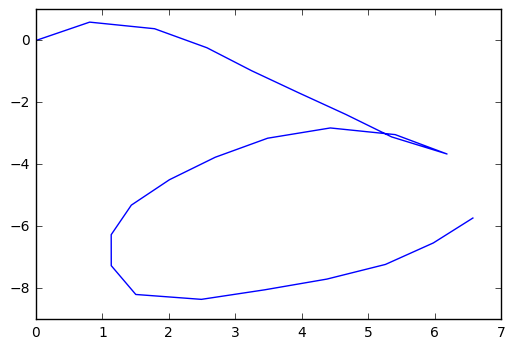

In [8]:
tracerLettre(X[0])

## Apprentissage d'un modèle CM (max de vraisemblance)

### 1. Discrétisation

In [9]:
def discretise(X,d):
    intervalle=360./d
    Xd=np.array(X)
    for i in range(len(X)):
        Xd[i]=np.floor(X[i]/intervalle)
    return Xd

In [10]:
print (discretise(X,20)[0])

[  2.  19.  17.  17.  17.  17.  17.  18.   7.   9.  11.  12.  12.  13.  14.
  15.  16.  19.   0.   1.   1.   2.   2.]


### 2. Regrouper les indices des signaux par classe (pour faciliter l'apprentissage)

In [11]:
def groupByLabel(y):
    index = []
    for i in np.unique(y): # pour toutes les classes
        ind, = np.where(y==i)
        index.append(ind)
    return index

In [12]:
index=groupByLabel(Y)
print (index)

[array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]), array([11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]), array([22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]), array([33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43]), array([44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54]), array([55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65]), array([66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76]), array([77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87]), array([88, 89, 90, 91, 92, 93, 94, 95, 96, 97]), array([ 98,  99, 100, 101, 102, 103, 104, 105, 106, 107]), array([108, 109, 110, 111, 112, 113, 114, 115, 116, 117]), array([118, 119, 120, 121, 122, 123, 124, 125, 126, 127]), array([128, 129, 130, 131, 132, 133, 134, 135, 136, 137]), array([138, 139, 140, 141, 142, 143, 144, 145, 146, 147]), array([148, 149, 150, 151, 152, 153, 154, 155, 156, 157]), array([158, 159, 160, 161, 162, 163, 164, 165, 166, 167]), array([168, 169, 170, 171, 172, 173, 174, 175, 176, 177]), array([178, 179, 180, 181, 182, 183, 184, 185, 186, 18

### 3. Apprendre les modèles CM

In [13]:
def learnMarkovModel(Xc,d):
    A = np.zeros((d,d))
    Pi = np.zeros(d)
    for X in Xc:
        i=X[0]
        Pi[i]+=1.
        for j in X[1:]:
            A[i][j]+=1.
            i=j
    
    A = A/np.maximum(A.sum(1).reshape(d,1),1) # normalisation
    Pi = Pi/Pi.sum()
    return (Pi,A)

In [14]:
print (learnMarkovModel(discretise(X[index[0][0]:index[1][0]],20),20))

(array([ 0.27272727,  0.        ,  0.09090909,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.18181818,  0.27272727,  0.18181818]), array([[ 0.4       ,  0.45      ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.1       ,  0.05      ],
       [ 0.13333333,  0.66666667,  0.2       ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.2       ,  0.6       ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.

/home/like/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:6: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/like/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:8: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


### 4. Stocker les modèles dans une liste

In [15]:
def model(d):

	Xd = discretise(X,d)  # application de la discretisation
	index = groupByLabel(Y)  # groupement des signaux par classe
	models = []
	for cl in range(len(np.unique(Y))): # parcours de toutes les classes et optimisation des modeles
		models.append(learnMarkovModel(Xd[index[cl]], d))
	return Xd,models

In [16]:
d=20
Xd,models=model(d)
print (len(Xd))
print (models[0])

268
(array([ 0.27272727,  0.        ,  0.09090909,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.18181818,  0.27272727,  0.18181818]), array([[ 0.4       ,  0.45      ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.1       ,  0.05      ],
       [ 0.13333333,  0.66666667,  0.2       ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.2       ,  0.6       ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,

/home/like/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:6: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/like/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:8: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


### 5. Probabilité d'une séquence dans un modèle

In [17]:
def probaSequence(s,Pi,A):
	
	j=s[0]
	p=Pi[j]
	for i in s[1:]:
		p*=A[j][i]
		j=i
	return np.log(p)

### 6. Application de la méthode précédente pour tous les signaux et tous les modèles de lettres

In [18]:
print (probaSequence(Xd[0],models[0][0],models[0][1]))
proba = np.array([[probaSequence(Xd[i], models[cl][0], models[cl][1]) for i in range(len(Xd))]for cl in range(len(np.unique(Y)))])
print (proba)

/home/like/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/like/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:6: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/like/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:8: RuntimeWarning: divide by zero encountered in log


-27.9933698208
[[-27.99336982 -24.00913067 -31.55305134 ...,         -inf         -inf
          -inf]
 [        -inf         -inf         -inf ...,         -inf         -inf
          -inf]
 [        -inf         -inf         -inf ...,         -inf         -inf
          -inf]
 ..., 
 [        -inf         -inf         -inf ...,         -inf         -inf
          -inf]
 [        -inf         -inf         -inf ...,         -inf         -inf
          -inf]
 [        -inf         -inf         -inf ..., -28.38500135 -26.85388545
  -36.27352933]]


### 7. Evaluation des performances

In [19]:
def evalPerformances(Y):
	Ynum = np.zeros(Y.shape)
	for num,char in enumerate(np.unique(Y)):
		Ynum[Y==char] = num
	pred = proba.argmax(0)
	print (np.where(pred != Ynum, 0.,1.).mean())

In [20]:
evalPerformances(Y)

0.914179104478
